In [109]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('tf').getOrCreate()

In [110]:
df = spark.read.csv("BankChurners.csv", inferSchema=True, header=True)
df.printSchema()

root
 |-- CLIENTNUM: integer (nullable = true)
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (n

In [111]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

In [112]:
df = df.drop('CLIENTNUM',
             'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
             'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2')
df.printSchema()

root
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)



In [113]:
df.describe().show()

+-------+-----------------+-----------------+------+------------------+---------------+--------------+---------------+-------------+------------------+------------------------+----------------------+---------------------+-----------------+-------------------+-----------------+--------------------+-----------------+-----------------+-------------------+---------------------+
|summary|   Attrition_Flag|     Customer_Age|Gender|   Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|    Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|     Credit_Limit|Total_Revolving_Bal|  Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|  Total_Trans_Amt|   Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-------+-----------------+-----------------+------+------------------+---------------+--------------+---------------+-------------+------------------+------------------------+----------------------+---------------------+-----------------+-------

In [114]:
#Porcentaje de clientes vigentes y abandonos

churns = df.groupby('Attrition_Flag').count().collect()

list(map(lambda x: 100*x['count']/10127, churns))

[83.934037720944, 16.065962279055988]

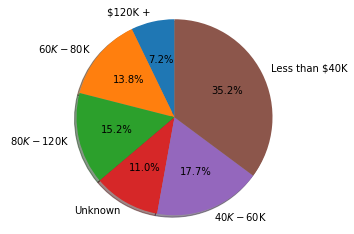

In [115]:
import matplotlib.pyplot as plt

#Distribución de categorías

levels = df.groupby('Income_Category').count().collect()

fig1, ax1 = plt.subplots()
ax1.pie(list(map(lambda x: x['count'], levels)), labels=list(map(lambda x: x['Income_Category'], levels)), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

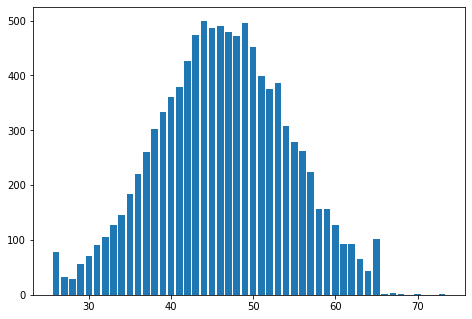

In [116]:
ages = df.groupby('Customer_Age').count().sort('Customer_Age').collect()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(map(lambda x: x['Customer_Age'], ages)),list(map(lambda x: x['count'], ages)))
plt.show()

In [117]:
df.groupby('Customer_Age').count().sort('Customer_Age').show()

+------------+-----+
|Customer_Age|count|
+------------+-----+
|          26|   78|
|          27|   32|
|          28|   29|
|          29|   56|
|          30|   70|
|          31|   91|
|          32|  106|
|          33|  127|
|          34|  146|
|          35|  184|
|          36|  221|
|          37|  260|
|          38|  303|
|          39|  333|
|          40|  361|
|          41|  379|
|          42|  426|
|          43|  473|
|          44|  500|
|          45|  486|
+------------+-----+
only showing top 20 rows



In [118]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

gender_indexer = StringIndexer(inputCol='Gender', outputCol='Gender_index')
education_indexer = StringIndexer(inputCol='Education_Level',outputCol='Education_Level_index')
status_indexer = StringIndexer(inputCol='Marital_Status',outputCol='Marital_Status_index')
income_indexer = StringIndexer(inputCol='Income_Category',outputCol='Income_Category_index')
card_indexer = StringIndexer(inputCol='Card_Category',outputCol='Card_Category_index')
attrition_indexer = StringIndexer(inputCol='Attrition_Flag',outputCol='Attrition_Flag_index')

assembler = VectorAssembler(inputCols=[c for c in df.columns if c not in {'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Attrition_Flag'}],
                            outputCol='features')

pipeline = Pipeline(stages=[gender_indexer, education_indexer, status_indexer,
                            income_indexer, card_indexer, attrition_indexer, assembler])

df = pipeline.fit(df).transform(df)

In [119]:
scores = [df.corr('Attrition_Flag_index', c) \
 for c in df.columns \
 if c not in {'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Attrition_Flag', 'features'}]

In [120]:
names = [c \
 for c in df.columns \
 if c not in {'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Attrition_Flag', 'features'}]

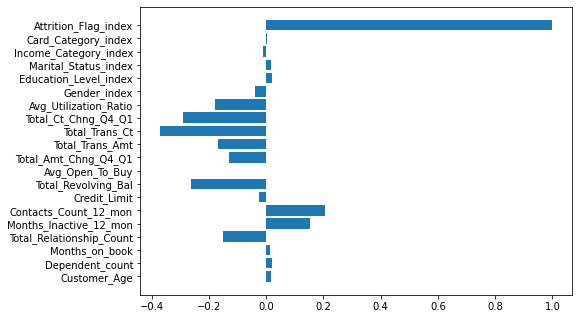

In [121]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(names,scores)
plt.show()